# GeeksForGeeks Data Analysis 

## All Imports

In [1]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
import pickle
import os

### -Importing Dataset

In [2]:
df=pandas.read_csv("medals.csv")

## Exploring The Data

In [3]:
df.columns

Index(['discipline_title', 'slug_game', 'event_title', 'event_gender',
       'medal_type', 'participant_type', 'participant_title', 'athlete_url',
       'athlete_full_name', 'country_name', 'country_code',
       'country_3_letter_code'],
      dtype='object')

In [4]:
df.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE


In [5]:
df.describe()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
count,21697,21697,21697,21697,21697,21697,6584,17027,18073,21697,20195,21697
unique,86,53,1436,4,3,2,493,12116,12895,154,143,154
top,Athletics,tokyo-2020,Individual men,Men,BRONZE,Athlete,United States team,https://olympics.com/en/athletes/michael-phelp...,Michael PHELPS,United States of America,US,USA
freq,3080,1188,215,13932,7529,15113,523,16,16,3094,3094,3094


### -Checking For Possible Values Of Some Columns

In [6]:
# possible values of participant_type
set(df.participant_type)

{'Athlete', 'GameTeam'}

In [7]:
# possible values of event_gender
set(df.event_gender)

{'Men', 'Mixed', 'Open', 'Women'}

In [8]:
# possible values of medal_type
set(df.medal_type)

{'BRONZE', 'GOLD', 'SILVER'}

## Preprocessing The Data

### -Cleaning The Data

In [9]:
# Checking for null values
for i in df.columns:
    if df[i].isnull().any():
        print(i)

participant_title
athlete_url
athlete_full_name
country_code


In [10]:
df['participant_title'].isnull().sum()

15113

In [11]:
df['participant_title'].size

21697

<Axes: >

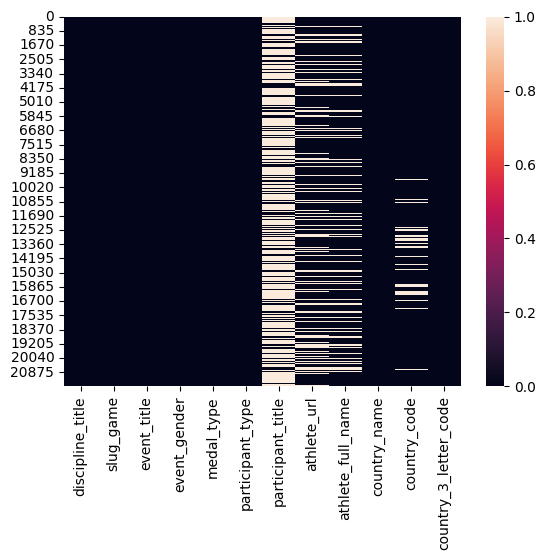

In [12]:
# Checking all null values more clearly
sns.heatmap(df.isnull())
# We can fill up country codes later on as we have 3 letter code, so for now, we will ignore that and fix the others

In [13]:
# common nulls between participant title and athlete full name and athlete url
p_af_url=0
# common nulls between participant title and athlete full name
p_af=0
# common nulls between participant title and athlete url
p_url=0
for i in df.index:
    if str(df['participant_title'][i])=="nan" and str(df['athlete_full_name'][i])=="nan" and str(df['athlete_url'][i])=="nan":
        p_af_url+=1
    elif str(df['participant_title'][i])=="nan" and str(df['athlete_full_name'][i])=="nan":
        p_af+=1
    elif str(df['participant_title'][i])=="nan" and str(df['athlete_url'][i])=="nan":
        p_url+=1  

In [14]:
print(p_af_url)
print(p_url)
print(p_af)

0
888
0


### Filling up blank athlete_full_names with athlete_url

In [15]:
def to_camel_case(text):
    newString=""
    for ind,i in enumerate(text):
        if ind==0:
            newString+=i.upper()
        else:
            newString+=i
    return newString

# Athlete names
for i in df.index:
    athleteUrl=df['athlete_url'][i]
    
#     A reason is given below in the markdown for this
    if type(athleteUrl)!=float and type(df['athlete_full_name'][i])==float:
        
#         Removing unnecessary parts
        athleteUrl=athleteUrl.replace("https://olympics.com/en/athletes/","")
        athleteUrl=athleteUrl.replace("-"," ")
        athleteName=""
#         Working with string cases
        athleteUrl=athleteUrl.split(" ")
#     Camel case
        if len(athleteUrl)==1:
            athleteName=to_camel_case(athleteUrl[0])
        else:
            
            for ind,name in enumerate(athleteUrl):
                if ind==0:
                    athleteName+=to_camel_case(athleteUrl[0])+" "
                else:
#                     Capital case

                    if ind!=len(athleteUrl)-1:
                        athleteName+=name.upper()+" "
                    else:
                        athleteName+=name.upper()
            
#         print(athleteName)
        df['athlete_full_name'][i]=athleteName        


In the above code, we have mentioned a condition like 
```Python
if type(athleteUrl)!=float and type(df['athlete_full_name'][i])==float
```

This suggests that we only want to fill up the athlete names which are not prefilled, and we also want to ignore the NULL urls

In [16]:
# Checking for any single word names (names without title)
for i in df.index:
    if type((df.athlete_full_name[i]))!=float:
        if len(df.athlete_full_name[i].split(" "))==1:
            print(i)
# There are no such values

### Filling up blank participant_titles with athlete_full_name

In [17]:
count=0
for i in df.index:
    a=df.participant_title[i]
    if type(a)!=float:
        print(i," ",a)
        count+=1
#     to only display 10, so that doesn't make issues while reviewing in Github
    if count==10:
        break
        
# We can see , we need to substitude the null values of participant_titles with country name + " team"
# as we dont know whether its a duo or not, or what are their names.

0   Italy
1   Italy
2   Norway
3   Norway
4   Sweden
5   Sweden
6   Great Britain
7   Japan
8   Sweden
9   Sweden


In [18]:
for i in df.index:
    countryN=df.country_name[i]
    if type(countryN)!=float and type(df.participant_title[i])==float:
        df.participant_title[i]=countryN+" team"

#     Also filling the rows which have country names but not the word "team"
    if type(countryN)!=float:
        if df.participant_title[i]!=float and "/" not in df.participant_title[i] and "team" not in df.participant_title[i]:
            df.participant_title[i]+=" team"
        

In [19]:
df.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE


In [20]:
df['athlete_full_name'].isnull().sum()

3624

<Axes: >

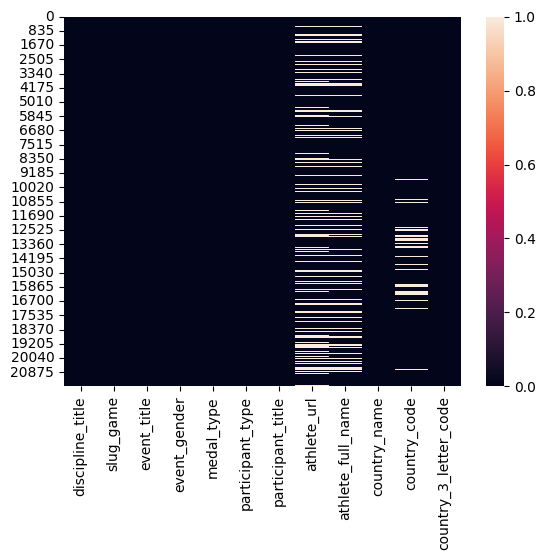

In [21]:
# Using heatmap again to check the progress
sns.heatmap(df.isnull())

### Dropping the athlete_url column

In [22]:
df=df.drop(['athlete_url'],axis=1)

We dont need this column anymore as it can't give any insights to us, it can't be fixed either

### Filling country codes

We can observe , that some country names seem unique while they are not, for example "ROC" and "Republic of China" are same,
so, we need to fill up such values

In [23]:
a=[]
for i in df.index:
    if type(df.country_code[i])==float:
        a.append(df.country_name[i])
print(set(a))

{'Bohemia', 'United Arab Republic', 'Trinidad and Tobago', 'MIX', 'Soviet Union', 'Unified Team', 'Lebanon', 'Namibia', 'Australasia', 'West Indies Federation', 'Olympic Athletes from Russia'}


These country names have either changed or they are no longer a country or it is from a "Mixed" category
So, we should update these values, with proper ones

In [24]:
toBeRemoved=[]
for i in df.index:
    name=df.country_name[i]
    if "People's Republic of China"==name:
        df.country_name[i]="China"
    elif "Russian Federation"==name or "Olympic Athletes from Russia"==name:
        df.country_name[i]="Russia"
    elif "Soviet Union"==name or "Unified Team"==name:
        df=df.drop(i)
    elif "Australasia"==name:
        df.country_name[i]="Australia"
    elif "Trinidad and Tobago"==name:
        df.country_code[i]="TT"
    elif "Namibia" ==name:
        df.country_code[i]="NA"
    elif "Lebanon"==name:
        df.country_code[i]="LB"
    elif "United Arab Republic"==name:
        df.country_name[i]="Egypt"
    elif "Bohemia"==name:
        df.country_name[i]="Czech Republic"
    elif "West Indies Federation"==name or "MIX"==name:
        df=df.drop(i)
        
#     Changing country names for ease
    elif "United States Of America" ==name:
        df.country_name[i]="United States"
    elif "Great Britain"==name:
        df.country_name[i]="United Kingdom"
    

These indexes should be removed as they can't be fixed

The values are still not fixed , so we need to fix the rest of the values

In [25]:
b=[]
for i in df.index:
    if type(df.country_code[i])==float:
        b.append(df.country_name[i])
b=set(b)

In [26]:
b

{'Australia', 'Czech Republic', 'Egypt', 'Russia'}

In [27]:
# Dropping values and fixing other values
for i in df.index:
    if type(df.country_code[i])==float:
        name=df.country_name[i]
        if name=="Australia":
            df.country_code[i]="AU"
        elif name=="Czech Republic":
            df.country_code[i]="CZ"
        elif name=="Egypt":
            df.country_code[i]="EG"
        elif name=="Russia":
            df.country_code[i]="RU"
        else:
            df=df.drop(i)

### Checking for Null values again

<Axes: >

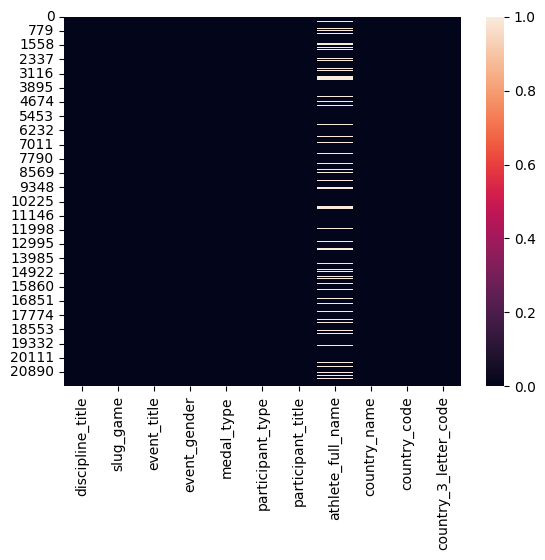

In [28]:
sns.heatmap(df.isnull())

As a final step of removal, we will remove all null athlete full name rows

In [29]:
for i in df.index:
    if type(df.athlete_full_name[i])==float:
        df=df.drop(i)

In [30]:
df.isnull().sum()

discipline_title         0
slug_game                0
event_title              0
event_gender             0
medal_type               0
participant_type         0
participant_title        0
athlete_full_name        0
country_name             0
country_code             0
country_3_letter_code    0
dtype: int64

### There are Finally no more NULL values!

### Checking for duplicates

In [31]:
df.duplicated().sum()
# There are no duplicates

0

We can now move to the next part, as there's no more cleaning work to do

## Feature engineering and more preprocessing

### Reindexing the data

In [32]:
df.index

Index([    0,     1,     2,     3,     4,     5,    12,    13,    14,    15,
       ...
       21685, 21688, 21689, 21690, 21691, 21692, 21693, 21694, 21695, 21696],
      dtype='int64', length=16865)

As some points are removed , the indices are still not proper, so we should reindex the data

In [33]:
indexes=[]
for i in range(len(df.index)):
    indexes.append(i)
    
df.index=pandas.Index(indexes)

In [34]:
df.index

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864],
      dtype='int64', length=16865)

### Adding a new  feature "year"

In [35]:
df.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_full_name,country_name,country_code,country_3_letter_code
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,Stefania CONSTANTINI,Italy,IT,ITA
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,Amos MOSANER,Italy,IT,ITA
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,Kristin SKASLIEN,Norway,NO,NOR
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,Magnus NEDREGOTTEN,Norway,NO,NOR
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,Almida DE VAL,Sweden,SE,SWE


In [36]:
Years=[]
for i in df.index:
    Years.append(int(df['slug_game'][i].split("-")[-1]))

In [37]:
df['years']=Years

In [38]:
for i in sorted(list(set(Years))):
    print(i,end=" ")
# Using " " as an end so its easier to display

1896 1900 1904 1908 1912 1920 1924 1928 1932 1936 1948 1952 1956 1960 1964 1968 1972 1976 1980 1984 1988 1992 1994 1996 1998 2000 2002 2004 2006 2008 2010 2012 2014 2016 2018 2020 2022 

###  * So the given dataset contains data from `1896 - 2022`

### Merging age data scraped from internet

In [39]:
ageData=pandas.read_csv("finalname_year_age.csv")

In [40]:
ageData.head()

,name,birthyear,age
0,stefania constantini,1999,24.0
1,amos mosaner,1995,28.0
2,kristin skaslien,1986,37.0
3,magnus nedregotten,1990,33.0
4,almida de val,1997,26.0


In [41]:
ageData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12116 entries, 0 to 12115
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       12116 non-null  object 
 1   birthyear  12116 non-null  object 
 2   age        11975 non-null  float64
dtypes: float64(1), object(2)
memory usage: 284.1+ KB


In [42]:
ageData.isnull().sum()

name           0
birthyear      0
age          141
dtype: int64

141 null age values

In [43]:
ageData.index

RangeIndex(start=0, stop=12116, step=1)

So, there are about `12116-141=11975` values, we can calculate the nulls as a rough estimate

In [44]:
# Copying the names before changing the orginal data
athleteNames=df['athlete_full_name']

df['athlete_full_name'] = df['athlete_full_name'].apply(lambda x: x.lower())

In [45]:
df.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_full_name,country_name,country_code,country_3_letter_code,years
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,stefania constantini,Italy,IT,ITA,2022
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,amos mosaner,Italy,IT,ITA,2022
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,kristin skaslien,Norway,NO,NOR,2022
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,magnus nedregotten,Norway,NO,NOR,2022
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,almida de val,Sweden,SE,SWE,2022


### Merging DF with AgeData

In [46]:
ageData=ageData.rename(columns={'name':'athlete_full_name','birthyear':'birth_year','age':'age'})

df=pandas.merge(df,ageData,on='athlete_full_name', how='left')

In [47]:
df.head(50)

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_full_name,country_name,country_code,country_3_letter_code,years,birth_year,age
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,stefania constantini,Italy,IT,ITA,2022,1999,24.0
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,amos mosaner,Italy,IT,ITA,2022,1995,28.0
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,kristin skaslien,Norway,NO,NOR,2022,1986,37.0
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,magnus nedregotten,Norway,NO,NOR,2022,1990,33.0
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,almida de val,Sweden,SE,SWE,2022,1997,26.0
5,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,oskar eriksson,Sweden,SE,SWE,2022,1991,32.0
6,Freestyle Skiing,beijing-2022,Men's Moguls,Men,SILVER,Athlete,Canada team,mikael kingsbury,Canada,CA,CAN,2022,1992,31.0
7,Freestyle Skiing,beijing-2022,Men's Moguls,Men,GOLD,Athlete,Sweden team,walter wallberg,Sweden,SE,SWE,2022,NaN,NaN
8,Freestyle Skiing,beijing-2022,Men's Moguls,Men,BRONZE,Athlete,Japan team,ikuma horishima,Japan,JP,JPN,2022,1997,26.0
9,Freestyle Skiing,beijing-2022,Men's Freeski Halfpipe,Men,GOLD,Athlete,New Zealand team,nico porteous,New Zealand,NZ,NZL,2022,2001,22.0


<Axes: >

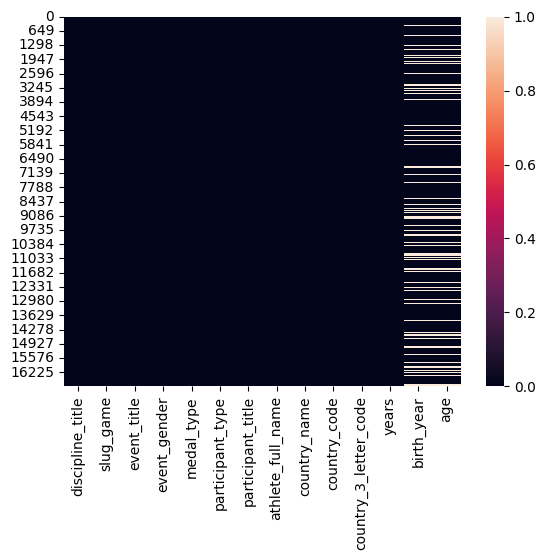

In [48]:
sns.heatmap(df.isnull())

In [49]:
df.query("athlete_full_name == 'almida de val'")
# Just testing a random athlete name to ensure everything's going well

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_full_name,country_name,country_code,country_3_letter_code,years,birth_year,age
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,almida de val,Sweden,SE,SWE,2022,1997,26.0


In [50]:
df['birth_year'].isnull().sum()

2888

almost 2888 values are going to be approximated, as they are null points.
We will take mean, as the measure of approximation

In [51]:
df['birth_year'] = pandas.to_numeric(df['birth_year'], errors='coerce').astype(float)

In [52]:
df.head(10)

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_full_name,country_name,country_code,country_3_letter_code,years,birth_year,age
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,stefania constantini,Italy,IT,ITA,2022,1999.0,24.0
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy team,amos mosaner,Italy,IT,ITA,2022,1995.0,28.0
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,kristin skaslien,Norway,NO,NOR,2022,1986.0,37.0
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway team,magnus nedregotten,Norway,NO,NOR,2022,1990.0,33.0
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,almida de val,Sweden,SE,SWE,2022,1997.0,26.0
5,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden team,oskar eriksson,Sweden,SE,SWE,2022,1991.0,32.0
6,Freestyle Skiing,beijing-2022,Men's Moguls,Men,SILVER,Athlete,Canada team,mikael kingsbury,Canada,CA,CAN,2022,1992.0,31.0
7,Freestyle Skiing,beijing-2022,Men's Moguls,Men,GOLD,Athlete,Sweden team,walter wallberg,Sweden,SE,SWE,2022,NaN,NaN
8,Freestyle Skiing,beijing-2022,Men's Moguls,Men,BRONZE,Athlete,Japan team,ikuma horishima,Japan,JP,JPN,2022,1997.0,26.0
9,Freestyle Skiing,beijing-2022,Men's Freeski Halfpipe,Men,GOLD,Athlete,New Zealand team,nico porteous,New Zealand,NZ,NZL,2022,2001.0,22.0


In [53]:
birthYears=[]

for i in df.index:
    if str(df.birth_year[i])!='nan':
        birthYears.append(int(df.birth_year[i]))
    else:
        birthYears.append(np.float64('nan'))


In [54]:
df['age']=df['years']-birthYears

### Filling other values with mean

In [55]:
round(df.age.mean())

26

### *On an average , the people were `26` when they participated

In [56]:
# Filling the values
df['age']=df.age.fillna(26)

In [57]:
# If null ages are filled with 26, birthyear must be ith olympicYear - 26 
df['birth_year']=df.birth_year.fillna(df['years']-26)

In [58]:
df.birth_year.isnull().sum()

0

In [59]:
df.age.isnull().sum()

0

### There are no more null values!

## More Analysis

### Things we found out till now:-
- #### Given dataset contains data from `1896 - 2022` olympic events
- #### On an average all the players were `aged 26`

In [60]:
df['medal_type'].value_counts().sort_values(ascending=False)

medal_type
BRONZE    5981
SILVER    5471
GOLD      5413
Name: count, dtype: int64

### * So, there are most `Bronze medal` and least `Silver medal` winners

### Ranking:

#### On the basis of most participanting countries:

In [61]:
# Showing the top 10 countries
df['country_name'].value_counts().sort_values(ascending=False)[:10]

country_name
United States of America    2616
Germany                      923
United Kingdom               812
France                       746
China                        734
Italy                        618
Sweden                       555
Russia                       525
Japan                        508
Australia                    505
Name: count, dtype: int64

### * `USA` has the most amount of medals

In [62]:
df.discipline_title.value_counts().sort_values(ascending=False)[:10]

discipline_title
Athletics              2597
Swimming               1393
Wrestling              1224
Boxing                  943
Shooting                722
Canoe Sprint            650
Gymnastics Artistic     642
Rowing                  618
Weightlifting           608
Sailing                 577
Name: count, dtype: int64

### * `Athletics`, `Swimming` and `Wrestling` players have most of the entries in our dataset
Athletics may include multiple sports like running, jumping, throwing ,etc.

In [63]:
len(set(df.slug_game))

53

### * In total `53` olympic events were organized between 1896-2022

In [64]:
athletes=df.drop_duplicates(subset='athlete_full_name', keep='first')

In [65]:
total_athletes=athletes.country_name.value_counts()

### Making new dataframe to contain data about countries and their medals 

In [66]:
#Grouping the countries by medal_type, so that there are 3 columns count, medal_type and country_name
medals_count = df.groupby(['medal_type', 'country_name']).size().reset_index(name='count')

# Creating a pivot table and passing the previous values, to convert medal_type to a column
pivot_table = medals_count.pivot_table(index='country_name', columns='medal_type', values='count', fill_value=0).reset_index()
pivot_table.rename(columns={'medal_type':'Index'},inplace=True)

In [67]:
pivot_table['BRONZE'].idxmax()

134

In [68]:
pivot_table['SILVER'].idxmax()

134

In [69]:
pivot_table['GOLD'].idxmax()

134

### * `USA` has the most Silver, Gold and Bronze medals

In [70]:
pivot_table['TotalMedals']=pivot_table['BRONZE']+pivot_table['GOLD']+pivot_table['SILVER']
pivot_table.head(2)

medal_type,country_name,BRONZE,GOLD,SILVER,TotalMedals
0,Afghanistan,2,0,0,2
1,Algeria,8,5,4,17


## Adding even more data from internet

### This dataset is taken from Kaggle
Here is the link to it : https://www.kaggle.com/datasets/iamsouravbanerjee/world-population-dataset

In [71]:
population=pandas.read_csv("world_population.csv")

In [72]:
population.head()

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00


In [73]:
# Dropping unnecessary columns
population=population.drop(['Capital','CCA3','World Population Percentage','Growth Rate','Area (km²)','Density (per km²)','Rank','1990 Population','1980 Population','1970 Population'],axis=1)

In [74]:
population['AvgPopulation']=round((population['2022 Population']+population['2020 Population']+population['2015 Population']+population['2010 Population']+population['2000 Population'])/5)

In [75]:
population.head()

,Country/Territory,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,AvgPopulation
0,Afghanistan,Asia,41128771,38972230,33753499,28189672,19542982,32317431.0
1,Albania,Europe,2842321,2866849,2882481,2913399,3182021,2937414.0
2,Algeria,Africa,44903225,43451666,39543154,35856344,30774621,38905802.0
3,American Samoa,Oceania,44273,46189,51368,54849,58230,50982.0
4,Andorra,Europe,79824,77700,71746,71519,66097,73377.0


In [76]:
population=population.drop(['2022 Population','2020 Population','2015 Population','2010 Population','2000 Population'],axis=1)
population=population.rename(columns={'Country/Territory':'country_name','AvgPopulation':'AvgPopulation'})

In [77]:
population.query("country_name=='India'")

,country_name,Continent,AvgPopulation
92,India,Asia,1.287335e+09


In [78]:
# To remove scientific notations
def NonScientific(number):
    return int(f'{number:.0f}')
population['AvgPopulation']=population['AvgPopulation'].apply(NonScientific)

In [79]:
pivot_table.to_csv("country_medals.csv")

In [80]:
population.isnull().sum()
# No null values:)

country_name     0
Continent        0
AvgPopulation    0
dtype: int64

In [81]:
newDf=pandas.merge(pivot_table, population, how='inner', on='country_name')

In [82]:
newDf.isnull().sum()

country_name     0
BRONZE           0
GOLD             0
SILVER           0
TotalMedals      0
Continent        0
AvgPopulation    0
dtype: int64

In [83]:
newDf.head()

,country_name,BRONZE,GOLD,SILVER,TotalMedals,Continent,AvgPopulation
0,Afghanistan,2,0,0,2,Asia,32317431
1,Algeria,8,5,4,17,Africa,38905802
2,Argentina,30,18,19,67,South America,42394862
3,Armenia,8,2,8,18,Asia,2915898
4,Australia,193,158,154,505,Oceania,23340966


In [84]:
pandas.get_dummies(newDf, columns=['Continent']).head()

,country_name,BRONZE,GOLD,SILVER,TotalMedals,AvgPopulation,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America
0,Afghanistan,2,0,0,2,32317431,False,True,False,False,False,False
1,Algeria,8,5,4,17,38905802,True,False,False,False,False,False
2,Argentina,30,18,19,67,42394862,False,False,False,False,False,True
3,Armenia,8,2,8,18,2915898,False,True,False,False,False,False
4,Australia,193,158,154,505,23340966,False,False,False,False,True,False


In [85]:
newDf=pandas.get_dummies(newDf, columns=['Continent'])

In [86]:
correlation_matrix = newDf[['AvgPopulation','Continent_Africa','Continent_Asia','Continent_Europe','Continent_North America','Continent_Oceania','Continent_South America', 'BRONZE', 'SILVER', 'GOLD']].corr()

In [87]:
correlation_matrix

,AvgPopulation,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,BRONZE,SILVER,GOLD
AvgPopulation,1.000000,-0.053259,0.256807,-0.113382,-0.075800,-0.045223,-0.018046,0.181770,0.228380,0.303255
Continent_Africa,-0.053259,1.000000,-0.300530,-0.339588,-0.192945,-0.094920,-0.154014,-0.248130,-0.234012,-0.224365
Continent_Asia,0.256807,-0.300530,1.000000,-0.380749,-0.216332,-0.106425,-0.172682,-0.150408,-0.144696,-0.114939
Continent_Europe,-0.113382,-0.339588,-0.380749,1.000000,-0.244447,-0.120256,-0.195125,0.464003,0.458975,0.417264
Continent_North America,-0.075800,-0.192945,-0.216332,-0.244447,1.000000,-0.068327,-0.110865,-0.083407,-0.086718,-0.090828
Continent_Oceania,-0.045223,-0.094920,-0.106425,-0.120256,-0.068327,1.000000,-0.054540,0.062738,0.046063,0.065563
Continent_South America,-0.018046,-0.154014,-0.172682,-0.195125,-0.110865,-0.054540,1.000000,-0.109842,-0.116783,-0.116211
BRONZE,0.181770,-0.248130,-0.150408,0.464003,-0.083407,0.062738,-0.109842,1.000000,0.984844,0.966277
SILVER,0.228380,-0.234012,-0.144696,0.458975,-0.086718,0.046063,-0.116783,0.984844,1.000000,0.981382
GOLD,0.303255,-0.224365,-0.114939,0.417264,-0.090828,0.065563,-0.116211,0.966277,0.981382,1.000000


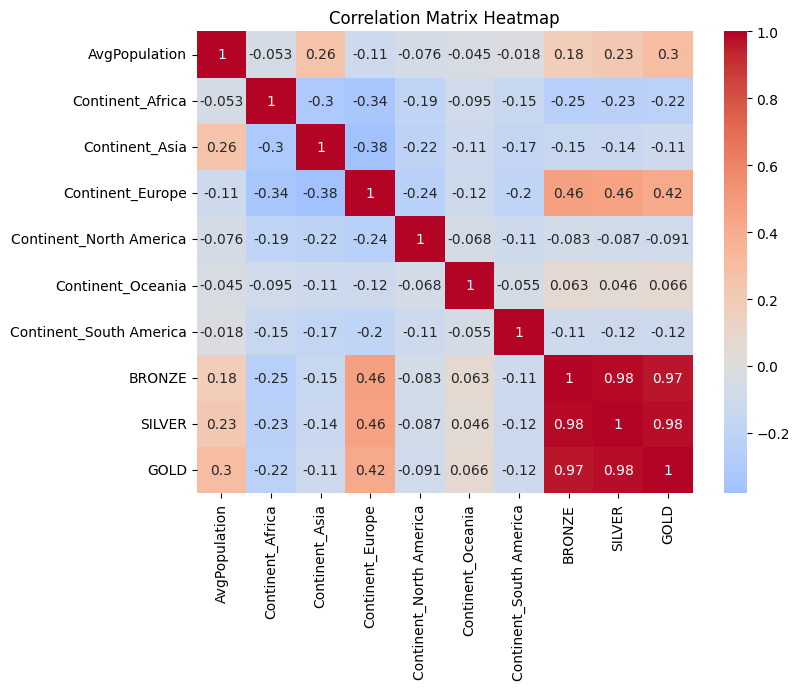

In [88]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

### *As the above data shows, if the country is from `Europe` or from `Oceania/Australia`
### *It has more probability of receiving any medals

### *But if they belong to `Africa`, they have lesser probability of receiving any medals

## Visualization

### Bar Graphs:

#### Country Medal ranking

In [89]:
CountryOnlyMedals=pandas.DataFrame({'countryName':pivot_table['country_name'],'medals':pivot_table['TotalMedals']})

In [90]:
CountryOnlyMedals=CountryOnlyMedals.sort_values(by='medals',ascending=False)[:10]
CountryOnlyMedals

,countryName,medals
134,United States of America,2616
46,Germany,923
132,United Kingdom,812
42,France,746
21,China,734
63,Italy,618
118,Sweden,555
103,Russia,525
65,Japan,508
4,Australia,505


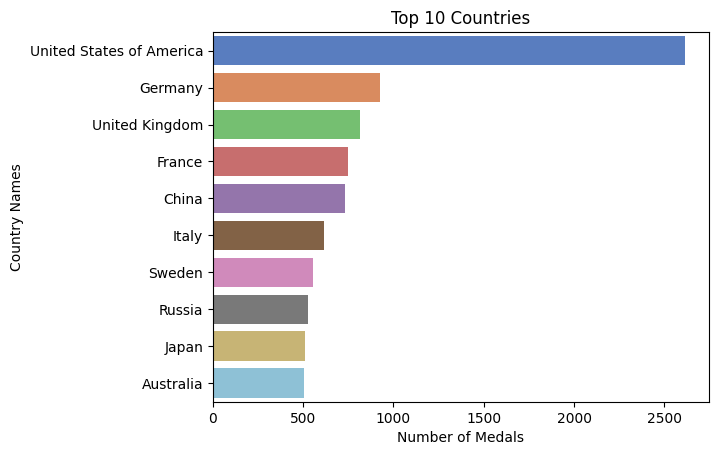

In [91]:
sns.barplot(x=CountryOnlyMedals.medals, y=CountryOnlyMedals.countryName, palette='muted')
plt.xlabel('Number of Medals')
plt.ylabel('Country Names')
plt.title('Top 10 Countries')
plt.show()

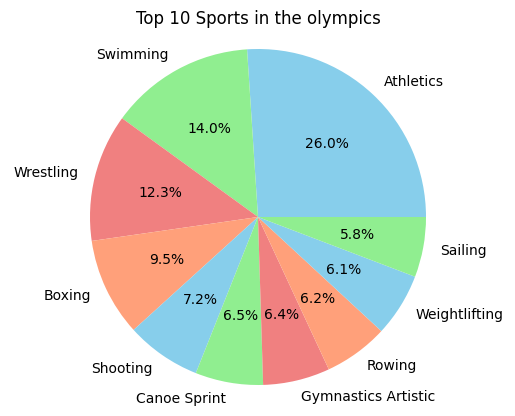

In [92]:
sports=list(df.discipline_title.value_counts().sort_values(ascending=False)[:10].keys())
values=list(df.discipline_title.value_counts().sort_values(ascending=False)[:10])

plt.pie(values, labels=sports, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon'])
plt.axis('equal')
plt.title('Top 10 Sports in the olympics')
plt.show()


### *The GDP of a country may also be a factor of higher success rate, as the top countries are developed and have higher GDP

## Model Training

We are going to train a model to predict number of bronze, silver and gold medals a country can win, using its continent and average population

### Splitting and training 3 models

In [93]:
Xdata=newDf[['AvgPopulation','Continent_Asia','Continent_Africa','Continent_Europe','Continent_South America','Continent_North America','Continent_Oceania']]
Ydata=list(newDf['GOLD'])
Y2data=list(newDf['SILVER'])
Y3data=list(newDf['BRONZE'])

X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.2, random_state=42)
X_train, X_test, y2_train, y2_test = train_test_split(Xdata, Y2data, test_size=0.2, random_state=42)
X_train, X_test, y3_train, y3_test = train_test_split(Xdata, Y3data, test_size=0.2, random_state=42)

GoldModel=RandomForestRegressor(n_estimators=100,random_state=42)
GoldModel.fit(X_train,y_train)

SilverModel=RandomForestRegressor(n_estimators=100,random_state=42)
SilverModel.fit(X_train,y2_train)

BronzeModel=RandomForestRegressor(n_estimators=100,random_state=42)
BronzeModel.fit(X_train,y3_train)

RandomForestRegressor(random_state=42)

### Testing

In [94]:
predictions=GoldModel.predict(X_test)
predictions2=SilverModel.predict(X_test)
predictions3=BronzeModel.predict(X_test)

In [95]:
predictions=[round(pred) for pred in predictions]
predictions2=[round(pred) for pred in predictions2]
predictions3=[round(pred) for pred in predictions3]

In [96]:
print(predictions)
print(predictions2)
print(predictions3)

[1, 1, 112, 196, 36, 196, 9, 7, 3, 2, 1, 1, 112, 2, 5, 36, 23, 5, 198, 3, 8, 36, 2, 13, 66]
[0, 0, 121, 198, 22, 198, 12, 13, 8, 3, 1, 1, 121, 3, 5, 43, 20, 8, 198, 5, 8, 31, 2, 9, 59]
[1, 1, 129, 239, 26, 239, 17, 20, 8, 6, 2, 1, 129, 6, 4, 44, 33, 10, 239, 7, 12, 32, 4, 11, 62]


In [97]:
print(y_test)
print(y2_test)
print(y3_test)

[2, 0, 152, 183, 158, 292, 3, 0, 3, 21, 3, 0, 21, 0, 0, 34, 1, 168, 254, 0, 0, 0, 2, 0, 19]
[1, 0, 135, 160, 154, 324, 15, 2, 2, 25, 1, 1, 36, 2, 1, 42, 6, 153, 283, 0, 1, 1, 3, 1, 17]
[2, 1, 167, 182, 193, 307, 14, 0, 0, 20, 8, 1, 47, 2, 0, 47, 9, 187, 275, 2, 0, 0, 0, 0, 15]


In [98]:
mse = mean_squared_error(y_test, predictions)
mse2 = mean_squared_error(y2_test, predictions2)
mse3 = mean_squared_error(y3_test, predictions3)

The model isn't much accurate ,but its kinda okay considering the fact that it takes only 2 features

## Exporting the model

In [99]:
joblib.dump(GoldModel, 'CountryGoldMedal.joblib')

['CountryGoldMedal.joblib']

In [100]:
joblib.dump(GoldModel, 'CountrySilverMedal.joblib')

['CountrySilverMedal.joblib']

In [101]:
joblib.dump(GoldModel, 'CountryBronzeMedal.joblib')

['CountryBronzeMedal.joblib']

## Testing the Model with random data

In [102]:
# 1cr population
n=input("Country name(optional, put anything): ")
avg_population=int(input("Average population: "))
continent_input=int(input("Continent name(in no.): "))
# In continent_input 0 means Asia, 1 means Africa,2 means Europe,3 means South America, 4 means North america, & 5 means Australia
toModel=pandas.DataFrame({'AvgPopulation':[avg_population],'Continent_Asia':[False],'Continent_Africa':[False],'Continent_Europe':[False],'Continent_South America':[False],'Continent_North America':[False],'Continent_Oceania':[False]})
lst=['Continent_Asia','Continent_Africa','Continent_Europe','Continent_South America','Continent_North America','Continent_Oceania']
toTweak=lst[continent_input]
toModel[toTweak]=[True]

predictions=GoldModel.predict(toModel)
predictions=[round(pred) for pred in predictions]
predictions2=SilverModel.predict(toModel)
predictions2=[round(pred) for pred in predictions2]
predictions3=BronzeModel.predict(toModel)
predictions3=[round(pred) for pred in predictions3]
print(n," will probably have ",predictions[0]," gold, ",predictions2[0]," silver and ",predictions[0],"bronze olympic medals, in total")

Country name(optional, put anything): RandomCountry
Average population: 10000
Continent name(in no.): 2
RandomCountry  will probably have  2  gold,  3  silver and  2 bronze olympic medals, in total


## Team members:

#### Shibam Roy(Captain)
role: Data Analyst
#### Ankush Roy
role: Presentation
#### Swadhin Maharana
role: Data Extraction/Fetching
#### Debdutta Barman 
role: Frontend developer